## BO with Warped Gaussian Processes

In this tutorial, we illustrate how to use learned input warping functions for robust bayesian optimization when the outcome may be non-stationary functions. When the lenglescales are non-stationarity in the raw input space, learning a warping function  that maps raw inputs to a warped space where the lengthscales are stationary can be useful because then standard stationary kernels can be used for to effectively model the function.

In general, we recommend for a relatively simple setup (like this one) to use [Ax](https://ax.dev), since this will simplify your setup (including the amount of code you need to write) considerably. See the [Using BoTorch with Ax](./custom_botorch_model_in_ax) tutorial. To use input warping with `MODULAR_BOTORCH`, we can pass the `warp_tf`, constructed as below, by adding `input_transform=warp_tf` argument to the `Surrogate(...)` call. 

We consider use a Kumaraswamy CDF as the class of input warping function and learn the concentration parameters ($a>0$ and $b>0$). Kumaraswamy CDFs are quite flexible and map inputs in [0, 1] to outputs in [0, 1]. This work follows the Beta CDF input warping proposed by Snoek et al., but replaces the Beta distribution Kumaraswamy distribution, which has a *differentiable* and closed-form CDF. 
   
   $$K_\text{cdf}(x) = 1 - (1-x^a)^b$$
   
This enables maximum likelihood (or maximum a posteriori) estimation of the CDF hyperparameters using gradient methods to maximize the likelihood (or posterior probability) jointly with the GP hyperparameters. (Snoek et al. use a fully Bayesian treatment of the CDF parameters). Each input dimension is transformed using a separate warping function.

We use the Noisy Expected Improvement (qNEI) acquisition function to optimize a synthetic Hartmann6 test function. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`). For this demonstration,
We first warp each input dimension through a different inverse Kumaraswamy CDF.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

[1] [J. Snoek, K. Swersky, R. S. Zemel, R. P. Adams. Input Warping for Bayesian Optimization of Non-Stationary Functions. Proceedings of the 31st International Conference on Machine Learning, PMLR 32(2):1674-1682, 2014.](http://proceedings.mlr.press/v32/snoek14.pdf)

In [1]:
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Problem setup

First, we define the sample parameters for the sigmoid functions that transform the respective inputs.

Text(0, 0.5, 'Transformed Value')

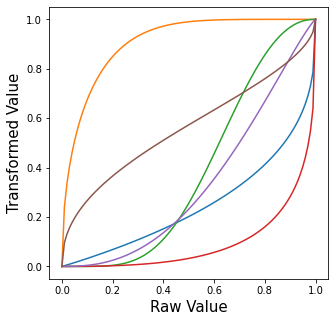

In [2]:
from torch.distributions import Kumaraswamy
import matplotlib.pyplot as plt

%matplotlib inline


fontdict = {"fontsize": 15}
torch.manual_seed(1234567890)
c1 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1
c0 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1
x = torch.linspace(0, 1, 101, dtype=dtype, device=device)
k = Kumaraswamy(concentration1=c1, concentration0=c0)
k_icdfs = k.icdf(x.unsqueeze(1).expand(101, 6))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(6):
    ax.plot(x.cpu(), k_icdfs[:, i].cpu())
ax.set_xlabel("Raw Value", **fontdict)
ax.set_ylabel("Transformed Value", **fontdict)

In [3]:
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(negate=True)


def obj(X):
    X_warp = k.icdf(X)
    return neg_hartmann6(X_warp)

#### Initial design

The models are initialized with 14 points in $[0,1]^6$ drawn from a scrambled sobol sequence.

We add observe the objectives with additive Gaussian noise with a standard deviation of 0.05.

In [4]:
from botorch.models import FixedNoiseGP
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = 0.05
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)


def generate_initial_data(n=14):
    # generate training data
    train_x = draw_sobol_samples(
        bounds=bounds, n=n, q=1, seed=torch.randint(0, 10000, (1,)).item()
    ).squeeze(1)
    exact_obj = obj(train_x).unsqueeze(-1)  # add output dimension

    best_observed_value = exact_obj.max().item()
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return train_x, train_obj, best_observed_value

#### Input warping and model initialization
We initialize the `Warp` input transformation and pass it a `FixedNoiseGP` to model the noiseless objective. The `Warp` object is a `torch.nn.Module` that contains the concentration parameters and applies the warping function in the `Model`'s `forward` pass.

In [5]:
from botorch.utils.transforms import standardize
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior


def initialize_model(train_x, train_obj, use_input_warping):
    if use_input_warping:
        # initialize input_warping transformation
        warp_tf = Warp(
            indices=list(range(train_x.shape[-1])),
            # use a prior with median at 1.
            # when a=1 and b=1, the Kumaraswamy CDF is the identity function
            concentration1_prior=LogNormalPrior(0.0, 0.75**0.5),
            concentration0_prior=LogNormalPrior(0.0, 0.75**0.5),
        )
    else:
        warp_tf = None
    # define the model for objective
    model = FixedNoiseGP(
        train_x,
        standardize(train_obj),
        train_yvar.expand_as(train_obj),
        input_transform=warp_tf,
    ).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use sequential $q=1$ optimization. A simple initialization heuristic is used to select the 20 restart initial locations from a set of 512 random points. 

In [6]:
from botorch.optim import optimize_acqf


num_restarts = 20 if not SMOKE_TEST else 2
raw_samples = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = obj(new_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return new_x, train_obj


def update_random_observations(best_random):
    """Simulates a quasi-random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = draw_sobol_samples(bounds=bounds, n=1, q=1).squeeze(1)
    next_random_best = obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [7]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 50 if not SMOKE_TEST else 5

verbose = False

best_observed_all_ei, best_observed_all_warp, best_random_all = [], [], []

torch.manual_seed(0)


# average over multiple trials
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_warp, best_random = [], [], []

    # call helper functions to generate initial training data and initialize model
    train_x_ei, train_obj_ei, best_observed_value_ei = generate_initial_data(n=14)
    mll_ei, model_ei = initialize_model(
        train_x_ei, train_obj_ei, use_input_warping=False
    )

    train_x_warp, train_obj_warp, = (
        train_x_ei,
        train_obj_ei,
    )
    best_observed_value_warp = best_observed_value_ei
    # use input warping
    mll_warp, model_warp = initialize_model(
        train_x_warp, train_obj_warp, use_input_warping=True
    )

    best_observed_ei.append(best_observed_value_ei)
    best_observed_warp.append(best_observed_value_warp)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_warp)

        ei = qNoisyExpectedImprovement(
            model=model_ei,
            X_baseline=train_x_ei,
        )

        ei_warp = qNoisyExpectedImprovement(
            model=model_warp,
            X_baseline=train_x_warp,
        )

        # optimize and get new observation
        new_x_ei, new_obj_ei = optimize_acqf_and_get_observation(ei)
        new_x_warp, new_obj_warp = optimize_acqf_and_get_observation(ei_warp)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])

        train_x_warp = torch.cat([train_x_warp, new_x_warp])
        train_obj_warp = torch.cat([train_obj_warp, new_obj_warp])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = obj(train_x_ei).max().item()
        best_value_warp = obj(train_x_warp).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_warp.append(best_value_warp)

        mll_ei, model_ei = initialize_model(
            train_x_ei, train_obj_ei, use_input_warping=False
        )
        mll_warp, model_warp = initialize_model(
            train_x_warp, train_obj_warp, use_input_warping=True
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, ei, ei_warp) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_warp:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_warp.append(best_observed_warp)
    best_random_all.append(best_random)


Trial  1 of 3 ..................................................
Trial  2 of 3 ..................................................
Trial  3 of 3 ..................................................

### Perform Bayesian Optimization
The Bayesian optimization "loop" simply iterates the following steps:
1. given a surrogate model, choose a candidate point
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials each of which do `N_BATCH=50` rounds of optimization.

*Note*: Running this may take a little while.

#### Plot the results
The plot below shows the log regret at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. In order to get a better estimate of the average performance early on, one would have to run a much larger number of trials `N_TRIALS` (we avoid this here to limit the runtime of this tutorial). 

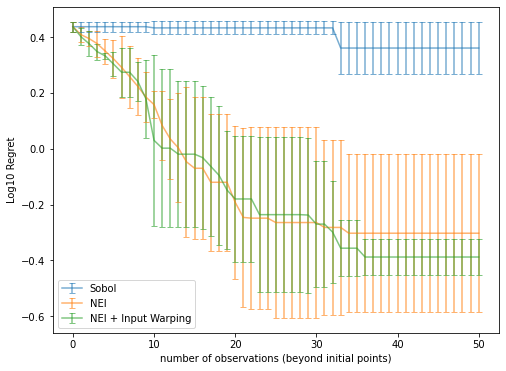

In [8]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(N_BATCH + 1)
y_ei = np.log10(GLOBAL_MAXIMUM - np.asarray(best_observed_all_ei))
y_ei_warp = np.log10(GLOBAL_MAXIMUM - np.asarray(best_observed_all_warp))
y_rnd = np.log10(GLOBAL_MAXIMUM - np.asarray(best_random_all))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    y_rnd.mean(axis=0),
    yerr=ci(y_rnd),
    label="Sobol",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.errorbar(
    iters,
    y_ei.mean(axis=0),
    yerr=ci(y_ei),
    label="NEI",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.errorbar(
    iters,
    y_ei_warp.mean(axis=0),
    yerr=ci(y_ei_warp),
    label="NEI + Input Warping",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.set(xlabel="number of observations (beyond initial points)", ylabel="Log10 Regret")
ax.legend(loc="lower left")